In [0]:
import pickle
import pylab
import numpy as np
import csv
import pandas as pd
import time as time
import scipy.ndimage as img
# from datetime import datetime
import scipy.misc as dfg
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import cv2

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1KrCyB8w_Su3H7RA1NokEtqZ_LjZ2EHob'})
downloaded.GetContentFile('train_max_x')    

train_images = pd.read_pickle('train_max_x') #train_set inputs

downloaded = drive.CreateFile({'id':'1n02LQULkmKrrzHdILoYBIa_182LlHAWs'}) 
downloaded.GetContentFile('test_max_x')    

test_images = pd.read_pickle('test_max_x') # test_set inputs

downloaded = drive.CreateFile({'id':'1CBnAaigf04_6GjMQCUbLcUCMW3Hb0mZg'})   
downloaded.GetContentFile('train_max_y.csv')    

train_max_y = pd.read_csv('train_max_y.csv') # train_set targets

(50000, 128, 128)
(50000, 2)


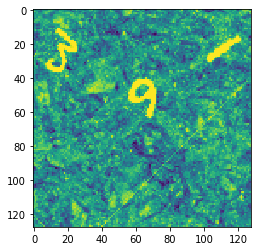

In [0]:
print(train_images.shape)
print(train_max_y.shape)

# the one we are playing with
tmp_train_images = train_images[3]
pylab.imshow(tmp_train_images)

In [0]:
# Canny edge detection
edge_exp = np.uint8(tmp_train_images)
edges = cv2.Canny(edge_exp,240,700)
print(edges)
plt.imshow(edges)
# plt.show()

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [0]:
# filter
edge_exp = np.uint8(train_images[8])
edges = cv2.Canny(edge_exp,240,700)
plt.imshow(edges)
print(edges)
# plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
# discussion: 2*0 may look identical to 8

# integrated in later function: thresholdBinary

# pylab.imshow(train_images[0])
# pylab.gray()
# for j in range(128):
#   for i in range(128):
#     if train_images[0][j][i] < 245:
#       train_images[0][j][i] = 0
    
# print(train_images[0][55])

In [0]:
# pre-processing data to normalize and eliminate background noise

# normalize then binary conversion on threshold, potentially dilation

def thresholdBinary(arr,threshold):

    arr = arr.astype('float')

    for i in range(arr.shape[0]):
        minval = arr[i,...].min()
        maxval = arr[i,...].max()
        if minval!= maxval:
            arr[i,...] -= minval
            arr[i,...] /= (maxval-minval)  # normally / 255
                                           
        for j in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                if arr[i,j,y] < threshold:
                    arr[i,j,y] = 0.0
                else:
                    arr[i,j,y] = 1.0
                    
        # apply dilation from scipy.ndimage
#         img.binary_dilation(arr[i])
        
    return arr

In [0]:
# image preprocessing

# x = thresholdBinary(train_images, 0.76)
# pylab.imshow(x[3])

# notice if RAM not enough.....
# X_train = thresholdBinary(train_images, 0.76).reshape(-1, 64, 64)

# X_train = cv2.Canny([(np.uint8(train_images[i]),240,700) for i in range(len(train_images))])

# test_Im = cv2.Canny([(np.uint8(test_images[i]),240,700) for i in range(len(test_images))])

X_train = []
for i in range(len(train_images)):
  X_train.append(cv2.Canny(np.uint8(train_images[i]),240,700))

test_Im = []
for i in range(len(test_images)):
  test_Im.append(cv2.Canny(np.uint8(test_images[i]),240,700))
  
# test_Im = test_images.reshape(-1, 64, 64)

# flatten image data
x_data = np.array( [np.array(X_train[i]).flatten() for i in range(len(train_images))] )
print (x_data.shape)
testIm_data = np.array( [np.array(test_Im[i]).flatten() for i in range(len(test_images))] )
print (testIm_data.shape)

(50000, 16384)
(10000, 16384)


In [0]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.ndimage as img

x = x_data    
y = np.array(train_max_y)[ : , 1]
test = testIm_data

t0 = time.time()
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', max_iter=7000).fit(x,y)
t1 = time.time()

time_train = t1-t0
print("Training time: %fs" % (time_train)) 

Training time: 3726.096042s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
# cross-validaton: Kfold
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

tc0 = time.time()
Cscore = cross_val_score(lr, x, y, cv=3)
tc1 = time.time()
time_cross = t2-t1

print("Cross validation took time: %fs" % (time_cross))      
print(Cscore)
print("Accuracy: %0.3f (+/- %0.2f)" % (Cscore.mean(), Cscore.std() * 2))

In [0]:
# write to file the final results on testing data
lr_pred = lr.predict(test)

seq_num = xrange(len(test))
with open('p3_lr_pred.csv','w+') as writeingFile:
  writer = csv.writer(writeingFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(['Id', 'Label'])

  for test_num in seq_num:          
      label = lr_pred[test_num]
      writer.writerow([str(test_num+1),str(label)])
        
uploaded = drive.CreateFile({'title': "p3_lr_pred.csv"})
uploaded.SetContentFile('p3_lr_pred.csv')
uploaded.Upload()      

In [0]:
# SVM model with RBF Kernel; in report we may play around with different penalty (C) to find the best

from sklearn import svm
from sklearn.metrics import classification_report

x = x_data     
y = np.array(train_max_y)[ : , 1]
test = testIm_data


# svm_model = svm.LinearSVC() 

svm_model = svm.SVC(C=1,kernel='rbf')   # the first trial with 10 stalled, let's try 1
t0 = time.time()
svm_model.fit(x, y)
t1 = time.time()

time_train = t1-t0
print("Training time: %fs" % (time_train)) 


# test result
svm_pred = svm_model.predict(test)
t2 = time.time()

time_train = t1-t0
time_predict = t2-t1
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))    

seq_num = xrange(len(test))
with open('p3_svm_pred.csv','w+') as writeingFile:
  writer = csv.writer(writeingFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(['Id', 'Label'])
  for test_num in seq_num:          
      label = svm_pred[test_num]
      writer.writerow([str(test_num+1),str(label)])     
         
uploaded = drive.CreateFile({'title': "p3_svm_pred.csv"})
uploaded.SetContentFile('p3_svm_pred.csv')
uploaded.Upload()                

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
# cross validation on svm
from tqdm import tqdm

tc0 = time.time()
Cscore = tqdm(cross_val_score(svm_model, x, y, cv=3))
tc1 = time.time()
time_cross = t2-t1

print("SVM Cross validation took time: %fs" % (time_cross))      
print(Cscore)
print("Accuracy: %0.3f (+/- %0.2f)" % (Cscore.mean(), Cscore.std() * 2))

NameError: ignored

In [0]:
# models I want to explore
#K-Nearest Neighbors
#Convolutional Neural Net (CNN - VGG)

In [0]:
# KNN model, experiment with different k
from sklearn.neighbors import KNeighborsClassifier
t0 = time.time()
knn = KNeighborsClassifier(n_neighbors=10) # try 4 8 10 12; 10  # should experiement different k for report
knn.fit(x,y)
t1 = time.time()

time_train = t1-t0
print("Training time: %fs" % (time_train)) 

# pred = knn.predict(test)


In [0]:
# try Keras model
import seaborn as sns
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


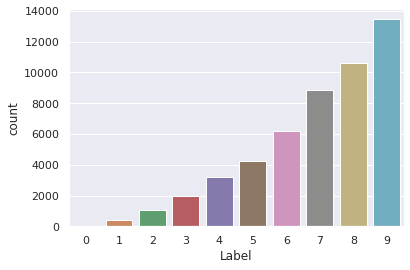

In [0]:
sns.set(palette='deep')
# showing the labels (results) from labelled training data

y_labeled = train_max_y
y_train = y_labeled['Label']
sns.countplot(y_train)

In [0]:
y_train.value_counts()

9    13452
8    10621
7     8866
6     6184
5     4223
4     3171
3     1991
2     1029
1      421
0       42
Name: Label, dtype: int64

In [0]:
def Keras_model():
  
  model = Sequential()
  
  model.add(Conv2D(64,kernel_size=3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=4,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))  # Dropout Regularization with Keras

  model.add(Flatten())   # https://keras.io/layers/core/#flatten
  model.add(Dense(128, activation='relu'))   # https://keras.io/layers/core/#dense
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

  model.summary()
  

In [0]:
epochs = 20
batch_size = 32  # use different batch sizes for testing and report

x1 = train_images

print(x1.shape)

# print(np.append(x1, x2, axis=1))

# Image data augmentation: 
# artificially expand the size of a training dataset by creating modified versions of images in the dataset.

datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2)

datagen.fit(x1)


(50000, 128, 128)


NameError: ignored

In [0]:
history = model.fit_generator(datagen.flow(x = x, y = y_train, batch_size = batch_size),
                   epochs = epochs, validation_data = (X_val, y_val),
                   verbose = 2, 
                   steps_per_epoch = X_train.shape[0] // batch_size,
                   callbacks=[learning_rate_reduction])

NameError: ignored

In [0]:
# pytorch
# https://nextjournal.com/gkoehler/pytorch-mnist

import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(X_train, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(test_Im, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)